In [2]:
import numpy as np
from src.black_sholes import black_scholes_call
from src.monte_carlo import monte_carlo
import matplotlib.pyplot as plt

## Алгоритм Монте-Карло

Как было сказано в теоретической части, алгоритм Монте-Карло - это по-большому счету просто симуляция некоторого процесса многократное количество раз и последующее усреднение результатов. Давайте продемонстрируем, как это работает для движения цены в модели Блэка-Шоулза.

In [10]:
S = 1000 # stock price S_{0}
K = 1500 # strike
T = 5 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.2 # annual volatility in %
steps = int(T * 100) # time steps
N = 1000 # number of trials

paths = monte_carlo(S, T, r, q, sigma, steps, N)
paths.shape # should be [steps, N]

(500, 1000)

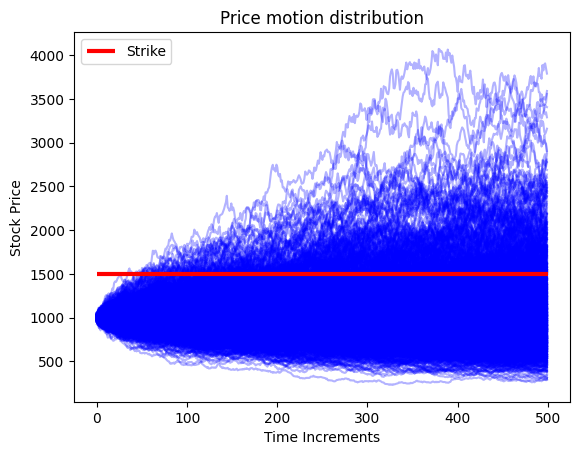

In [12]:
plt.plot(paths, color='blue', alpha=0.3)
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.hlines(K, 0, steps, colors='red', lw=3, label="Strike")
plt.legend()
plt.title("Price motion distribution")
plt.show()

Цена колл-опциона вычисляется $E[max(S - K, 0)]$. Так же надо не забыть учесть инфляцию и уменьшить цену.

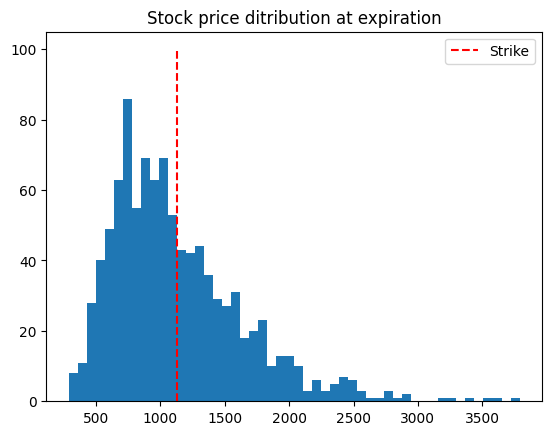

In [19]:
plt.hist(paths[-1, :], bins=50)
plt.vlines(np.mean(paths[-1]), 0, 100, colors='red', linestyles='--', label='Strike')
plt.legend()
plt.title("Stock price ditribution at expiration")
plt.show()

In [25]:
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs) * np.exp(-r*T) #discounting back to present value
print(f"Simulated price is {option_price}")
print(f"Statistical error of option price is {np.std(payoffs) / N**0.5}")

Simulated price is 69.49745433265329
Statistical error of option price is 8.246535870254874


Теперь воспользуемся формулой Блэка-Шоулза и узнаем аналитическую цену для наших параметров

In [20]:
bs_price = black_scholes_call(S, K, T, r, q, sigma)
print(f"Black Scholes Price is {bs_price}")

Black Scholes Price is 80.17589661210769


Видим, что цена получения с помощью МК достаточно сильно отличается от аналитической цены и ошибка также велика. Это связано с малым количеством путей, это главная проблема данного алгоритма, которая делает его очень ресурсозатратным.

## Зависимость ошибки Монте-Карло от количества путей


In [26]:
from tqdm.notebook import tqdm

Ns = [2**i for i in range(8, 21)]
errors = []

for N in tqdm(Ns):
    paths = monte_carlo(S, T, r, q, sigma, steps, N)
    payoffs = np.maximum(paths[-1]-K, 0)
    mc_price = np.mean(payoffs) * np.exp(-r*T)
    errors.append(abs(bs_price - mc_price))

  0%|          | 0/13 [00:00<?, ?it/s]

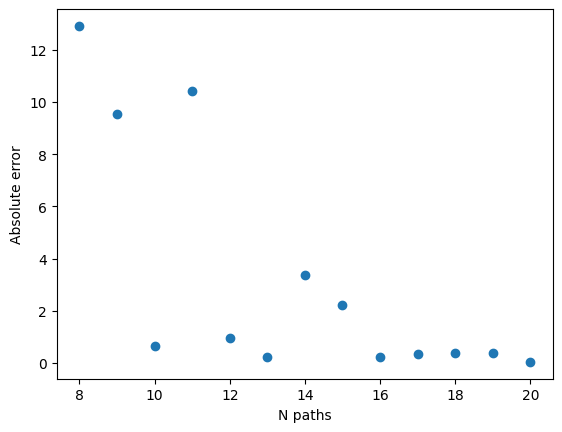

In [28]:
plt.scatter([i for i in range(8, 21)], errors)
plt.xlabel("N paths")
plt.ylabel("Absolute error")
plt.show()

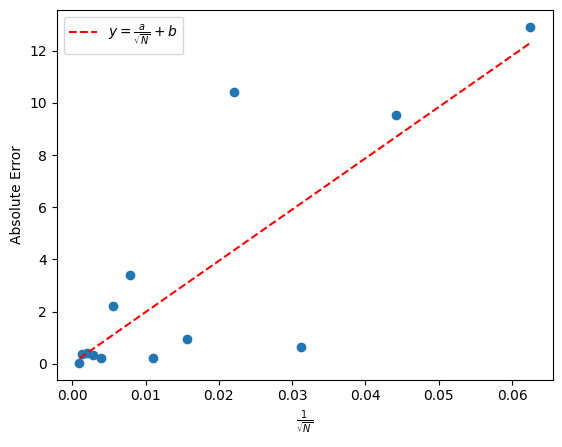

In [37]:
x = 1 / np.array(Ns)**0.5
coefs = np.polyfit(x, errors, deg=1)
line = np.linspace(x.min(), x.max(), 100)
plt.scatter(x, errors)
plt.plot(line, coefs[0] * line + coefs[1], ls='--', color='red', label=r'$y = \frac{a}{\sqrt{N}} + b$')
plt.xlabel(r'$\frac{1}{\sqrt{N}}$')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

Экспериментально полученную зависимость нельзя с уверенностью назвать прямой близкой к теории. Это может быть связано с численным интегрированием, в нем тоже накапливается ошибка. Однако главную мысль, которую мы должны извлечь, что для высокой точности необходимо выбирать большое количество путей. Обычно банки и фонды выбирают такое количество путей, чтобы получать относительную ошибку порядка $10^{-4}$. Для этого требуется очень много ресурсов, поэтому задача аппроксимации Монте-Карло более быстрыми алгоритмами, например, нейронными сетям является вполне акутальной, и многие финансовые компании ее решают.  